In [2]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys

from IPython import display
import time
import imageio
import pylab
import matplotlib.patches as patches
import datetime 

from data_processing_helpers import get_positions, get_position, get_pixels_from_world, in_collision, hit_obstacle

# SDD data set

In [4]:
dataset_path = "/home/q392358/Documents/FLORA/data/SDD/"

## Read the dataset and build a unique dataframe

In [12]:
# Read all scene annotations and store them in a unique dataframe 
# Each row will have this format: [scene_name, frameID, agentID, x, y, lost, occluded, interpolated, agent_type]
scenes_annotations_dataframe = pd.DataFrame(columns=["scene_name", "video_name", "frameID", "agentID", "x", "y", "lost", "occluded", "interpolated", "agent_type"],
                                            dtype=np.float64)

# Since the label is stored as a float number, we need this array to take their correspondent categorical value
agents_type = ["Biker", "Pedestrian", "Skater", "Cart", "Car", "Bus"]

for root, dirs, files in os.walk(dataset_path):
    if root != dataset_path:
        break;
    for scene_folder in dirs:
        if scene_folder == 'sdd':
            continue
        scene_dataframe = pd.read_csv(root + scene_folder + "/" + scene_folder + "_originalSDD.txt", sep=' ', header=None, 
                                 names=["frameID", "agentID", "x", "y", "lost", "occluded", "interpolated", "agent_type"])
        scene_dataframe["scene_name"] = scene_folder.split("_")[0]
        scene_dataframe["video_name"] = scene_folder
        scenes_annotations_dataframe = scenes_annotations_dataframe.append(scene_dataframe)

In [13]:
scenes_annotations_dataframe.head()

,agentID,agent_type,frameID,interpolated,lost,occluded,scene_name,video_name,x,y
0,0.0,1,0.0,0,0.0,0.0,quad,quad_0,488.5,221.5
1,0.0,1,1.0,1,0.0,0.0,quad,quad_0,488.5,221.5
2,0.0,1,2.0,1,0.0,0.0,quad,quad_0,488.5,221.5
3,0.0,1,3.0,1,0.0,0.0,quad,quad_0,491.0,221.5
4,0.0,1,4.0,1,0.0,0.0,quad,quad_0,491.0,221.5


## Overall statistics

In [14]:
videos = scenes_annotations_dataframe["video_name"].unique()
scenes = scenes_annotations_dataframe["scene_name"].unique()

print("Number of scenes: ", len(scenes))
print("Number of videos: ", len(videos))
print("Number of annotated frames: ", scenes_annotations_dataframe["frameID"].nunique())
print("Number of annotated agents: ", scenes_annotations_dataframe["agentID"].nunique())

Number of scenes:  8
Number of videos:  48
Number of annotated frames:  14558
Number of annotated agents:  1352


## Per-scene statistics

/home/q392358/.local/share/virtualenvs/safe_gan/lib/python3.6/site-packages/matplotlib/axes/_base.py:3455: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')


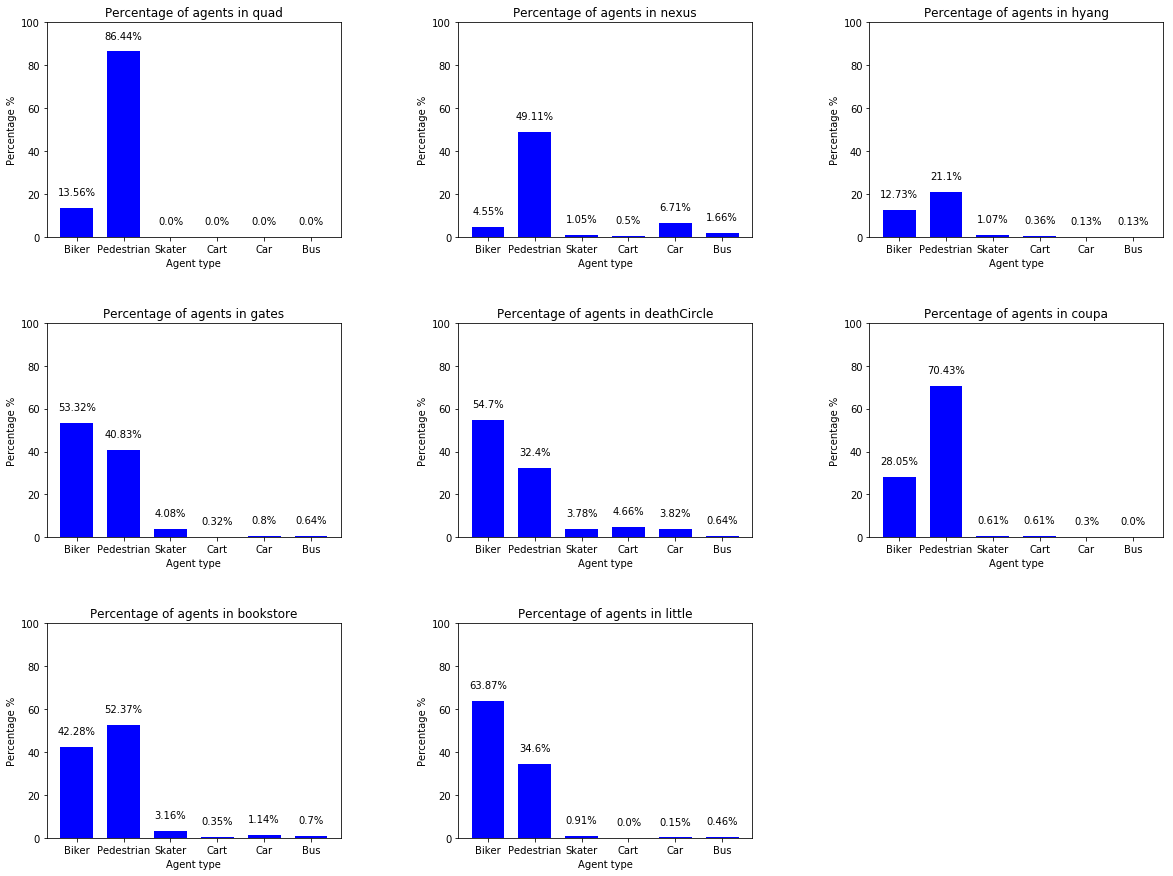

In [15]:
fig = plt.figure(figsize=(20,15))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i, scene in enumerate(scenes):
    percentage_values = []
    
    for agent_idx, agent in enumerate(agents_type):
        scene_agents_count = scenes_annotations_dataframe[(scenes_annotations_dataframe["scene_name"] == scene) & 
                                                           (scenes_annotations_dataframe["agent_type"] == float(agent_idx))].groupby(["agentID", "video_name"]).ngroups
        scene_count = scenes_annotations_dataframe[scenes_annotations_dataframe['scene_name'] == scene].groupby(["agentID", "video_name"]).ngroups
        
        agent_percentage = (scene_agents_count / scene_count)*100.0
        percentage_values.append(agent_percentage)
    
    ax = fig.add_subplot(3, 3, i+1)
    bar1 = ax.bar(range(len(percentage_values)), percentage_values, 0.70, color="b", tick_label=agents_type)
    ax.set_ylabel("Percentage %")
    ax.set_xlabel('Agent type')
    ax.set_title('Percentage of agents in ' + scene)
    # Set a clean upper y-axis limit.
    ax.set_ylim(ymax=100)
    
    rects = ax.patches
    for rect, label in zip(rects, percentage_values):
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width() / 2, height + 5, str(round(label,2)) + "%", ha='center', va='bottom')

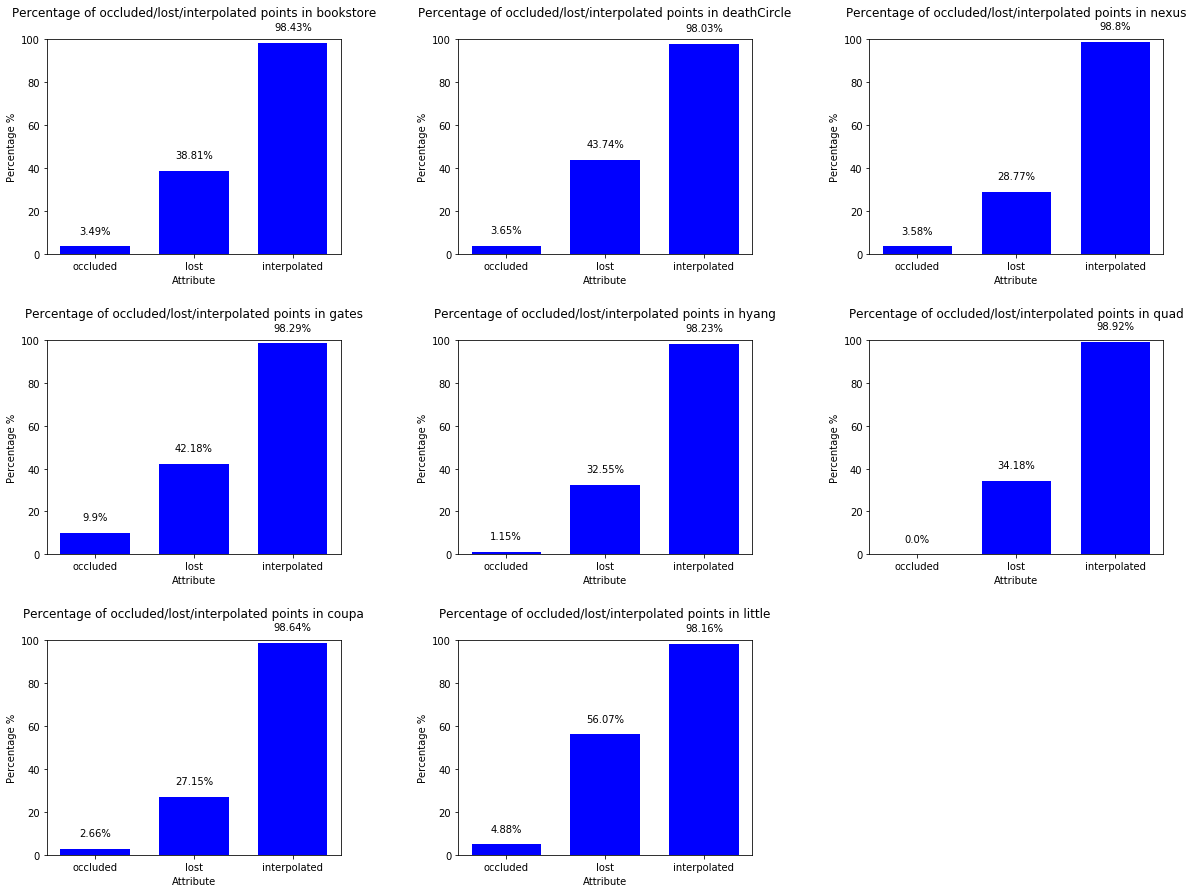

In [36]:
fig = plt.figure(figsize=(20,15))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i, scene in enumerate(scenes):
    percentage_values = []
    
    for attribute_idx, attribute in enumerate(["occluded", "lost", "interpolated"]):
        scene_attribute_count = scenes_annotations_dataframe[(scenes_annotations_dataframe["scene_name"] == scene) & 
                                                           (scenes_annotations_dataframe[attribute] == 1.0)].shape[0]
        scene_count = scenes_annotations_dataframe[scenes_annotations_dataframe['scene_name'] == scene].shape[0]
        
        attribute_percentage = (scene_attribute_count / scene_count)*100.0
        percentage_values.append(attribute_percentage)
    
    ax = fig.add_subplot(3, 3, i+1)
    bar1 = ax.bar(range(len(percentage_values)), percentage_values, 0.70, color="b", tick_label=["occluded", "lost", "interpolated"])
    ax.set_ylabel("Percentage %")
    ax.set_xlabel('Attribute')
    ax.set_title('Percentage of occluded/lost/interpolated points in ' + scene, y=1.08)
    # Set a clean upper y-axis limit.
    ax.set_ylim(ymax=100)
    
    rects = ax.patches
    for rect, label in zip(rects, percentage_values):
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width() / 2, height + 5, str(round(label,2)) + "%", ha='center', va='bottom')

# UCY data set

In [40]:
dataset_path = "/home/q392358/Documents/FLORA/data/UCY/"
frame_rate = 25

In [41]:
# Read all scene annotations and store them in a unique dataframe 
# Each row will have this format: [scene_name, frameID, agentID, x, y, lost, occluded, interpolated, agent_type]
scenes_annotations_dataframe = pd.DataFrame(columns=["scene_name", "video_name", "frameID", "agentID", "x", "y"],
                                            dtype=np.float64)

for root, dirs, files in os.walk(dataset_path):
    if root != dataset_path:
        break;
    for scene_folder in dirs:
        if scene_folder == 'ucy':
            continue
        scene_dataframe = pd.read_csv(root + scene_folder + "/" + scene_folder + ".txt", sep=' ', header=None, 
                                 names=["frameID", "agentID", "x", "y"])
        scene_dataframe["scene_name"] = scene_folder.split("_")[0]
        scene_dataframe["video_name"] = scene_folder
        scenes_annotations_dataframe = scenes_annotations_dataframe.append(scene_dataframe)
scenes_annotations_dataframe = scenes_annotations_dataframe.sort_values(['scene_name', 'video_name', 'frameID', 'agentID'])
scenes_annotations_dataframe.head()

,agentID,frameID,scene_name,video_name,x,y
0,1.0,0.0,students,students_3,9.050,6.038
1,2.0,0.0,students,students_3,11.344,7.398
2,3.0,0.0,students,students_3,6.082,3.604
3,4.0,0.0,students,students_3,2.273,6.205
4,5.0,0.0,students,students_3,13.680,6.539


In [12]:
videos = scenes_annotations_dataframe["video_name"].unique()
scenes = scenes_annotations_dataframe["scene_name"].unique()

print("Number of scenes: ", len(scenes))
print("Number of videos: ", len(videos))

tot_frames = [(max(scenes_annotations_dataframe[scenes_annotations_dataframe.video_name == video].frameID) - min(scenes_annotations_dataframe[scenes_annotations_dataframe.video_name == video].frameID)) / np.diff(scenes_annotations_dataframe[scenes_annotations_dataframe.video_name == video].frameID.unique())[0] for video in videos]
tot_agents = [len(scenes_annotations_dataframe[scenes_annotations_dataframe.video_name == video].agentID.unique()) for video in videos]

print("Number of annotated frames: ", tot_frames)
print("Number of annotated agents: ", tot_agents)

Number of scenes:  2
Number of videos:  3
Number of annotated frames:  [540.0, 901.0, 1051.0]
Number of annotated agents:  [434, 148, 204]


## Collision frequency

/home/q392358/.local/share/virtualenvs/safe_gan/lib/python3.6/site-packages/matplotlib/axes/_base.py:3455: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')


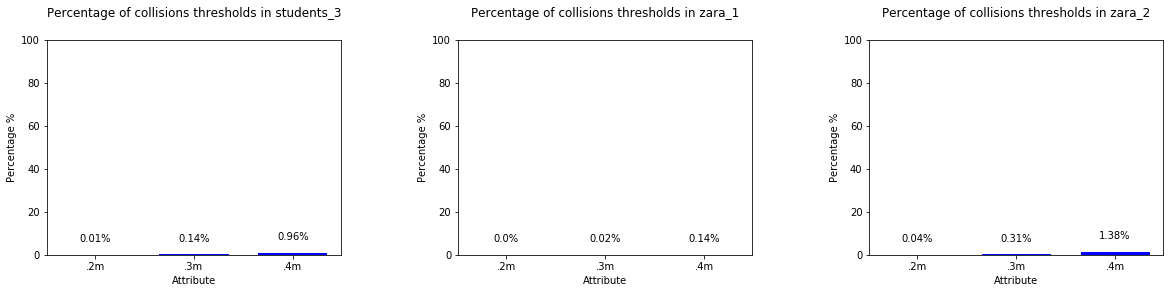

In [13]:
fig = plt.figure(figsize=(20,15))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

thresholds = [0.2, 0.3, 0.4]

collision = {}
for i, video in enumerate(videos):
    percentage_values = []
    
    for attribute_idx, attribute in enumerate(thresholds):
        collision = {}
        scene_annotations_dataframe = scenes_annotations_dataframe[scenes_annotations_dataframe.video_name == video]
        frames = scene_annotations_dataframe.frameID.unique()
        for frame in frames:
            current_frame = scene_annotations_dataframe[scene_annotations_dataframe.frameID == frame]
            if len(in_collision(current_frame, attribute)) > 0:
                collision[(video, frame)] = in_collision(current_frame, attribute) # one or more pedestrians colliding
        
        scene_attribute_count = len(collision)
        scene_count = scenes_annotations_dataframe[scenes_annotations_dataframe['video_name'] == video].shape[0]
        
        attribute_percentage = (scene_attribute_count / scene_count)*100.0
        percentage_values.append(attribute_percentage)
    
    ax = fig.add_subplot(3, 3, i+1)
    bar1 = ax.bar(range(len(percentage_values)), percentage_values, 0.70, color="b", tick_label=[".2m", ".3m", ".4m"])
    ax.set_ylabel("Percentage %")
    ax.set_xlabel('Attribute')
    ax.set_title('Percentage of collisions thresholds in ' + video, y=1.08)
    # Set a clean upper y-axis limit.
    ax.set_ylim(ymax=100)
    
    rects = ax.patches
    for rect, label in zip(rects, percentage_values):
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width() / 2, height + 5, str(round(label,2)) + "%", ha='center', va='bottom')

### Fixed threshold show corresponding frames

In [216]:
collision = {}
for video in videos:
    scene_annotations_dataframe = scenes_annotations_dataframe[scenes_annotations_dataframe.video_name == video]
    frames = scene_annotations_dataframe.frameID.unique()
    for frame in frames:
        current_frame = scene_annotations_dataframe[scene_annotations_dataframe.frameID == frame]
        if len(in_collision(current_frame)) > 0:
            collision[(video, frame)] = in_collision(current_frame) # one or more pedestrians colliding

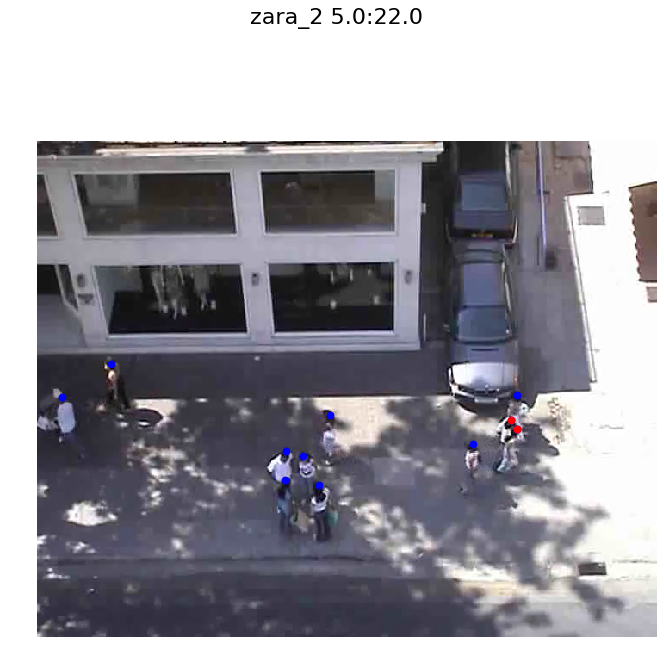

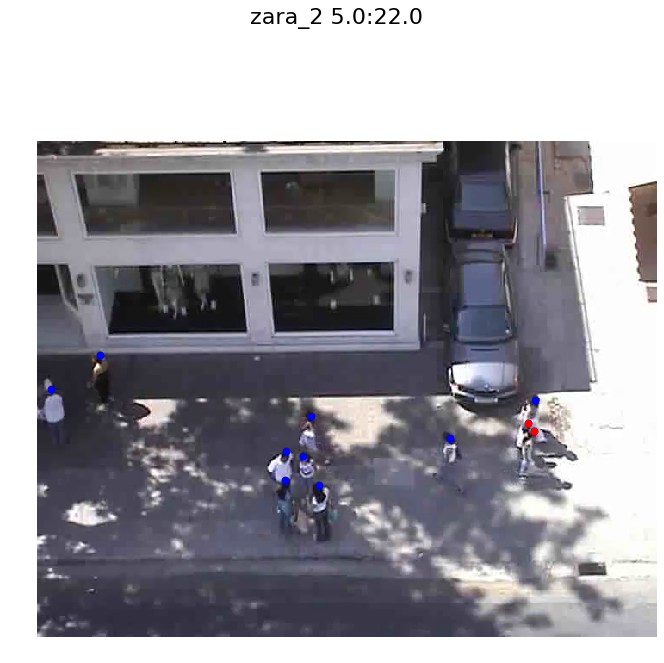

In [245]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10), dpi= 80, facecolor='w', edgecolor='k')
for key, peds in collision.items():
    (video, frame) = key
    scene_annotations_dataframe = scenes_annotations_dataframe[scenes_annotations_dataframe.video_name == video]
    frames = scene_annotations_dataframe.frameID.unique()
    video_num = video[-1]
    scene_name = video[:-2]
    
    path = '/home/q392358/Documents/FLORA/data/UCY/{}_{}'.format(scene_name, video_num)
    h_matrix = pd.read_csv(path + '/{}_homography.txt'.format(video), delim_whitespace=True, header=None).values
        
    filename = '/media/q392358/ba2b8f54-91f6-4e35-8323-e164edb98d11/stanford_campus_dataset/videos/{}/video{}/video.mov'.format(scene_name, video_num)
    vid = imageio.get_reader(filename,  'ffmpeg')
    #frame_rate = len(vid)/len(frames)        

    current_frame = scene_annotations_dataframe[scene_annotations_dataframe.frameID == frame]
    xy = np.transpose(np.stack([current_frame.x, current_frame.y]))
    pixels = get_pixels_from_world(xy, h_matrix)
    image = vid.get_data(int(frame))
    fig = pylab.figure(1)
    m, s = divmod(frame//frame_rate, 60)
    fig.suptitle('{} {}:{}'.format(video, m, s), fontsize=20)
    display.clear_output(wait=True)
    display.display(plt.gcf())
    ax.clear()
    ax.imshow(image)
    ax.scatter(pixels[:, 0], pixels[:, 1], color='blue')
    for couple in peds:
        pixs = get_pixels_from_world(np.vstack([get_position(current_frame, couple[0]), get_position(current_frame, couple[1])]), h_matrix)
        ax.scatter(pixs[:, 0], pixs[:, 1], color='red')
    ax.axis('off')
    time.sleep(0.1)
    
pylab.show()


# TRAJNET data set

In [4]:
root = '/home/q392358/Documents/FLORA/data/TRAJNET/trajnet/Training/'
dataset_paths = [root + "train/", root + "test/"]
frame_rate = 30

# Read all scene annotations and store them in a unique dataframe 
# Each row will have this format: [scene_name, frameID, agentID, x, y, lost, occluded, interpolated, agent_type]
scenes_annotations_dataframe = pd.DataFrame(columns=["scene_name", "video_name", "frameID", "agentID", "x", "y"],
                                            dtype=np.float64)

for dataset_path in dataset_paths:
    for root, dirs, files in os.walk(dataset_path):
        if root != dataset_path:
            break;
        for file_name in files:
            scene_dataframe = pd.read_csv(root + "/" + file_name, sep=' ', header=None, 
                                 names=["frameID", "agentID", "x", "y"])
            scene_dataframe["scene_name"] = file_name.split("_")[0]
            scene_dataframe["video_name"] = file_name[:-4]
            scenes_annotations_dataframe = scenes_annotations_dataframe.append(scene_dataframe)
scenes_annotations_dataframe = scenes_annotations_dataframe.sort_values(['video_name', 'scene_name', 'frameID', 'agentID'])
scenes_annotations_dataframe.head()

/home/q392358/.local/share/virtualenvs/safe_gan/lib/python3.6/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


,agentID,frameID,scene_name,video_name,x,y
0,100.0,0.0,bookstore,bookstore_0,1.73,14.39
20,129.0,0.0,bookstore,bookstore_0,7.13,-13.86
40,139.0,0.0,bookstore,bookstore_0,-11.63,18.01
60,194.0,0.0,bookstore,bookstore_0,-10.90,19.43
80,212.0,0.0,bookstore,bookstore_0,-4.33,17.57


In [5]:
videos = scenes_annotations_dataframe["video_name"].unique()
scenes = scenes_annotations_dataframe["scene_name"].unique()

print("Number of scenes: ", len(scenes))
print("Number of videos: ", len(videos))

tot_frames = [(max(scenes_annotations_dataframe[scenes_annotations_dataframe.video_name == video].frameID) - min(scenes_annotations_dataframe[scenes_annotations_dataframe.video_name == video].frameID)) / np.diff(scenes_annotations_dataframe[scenes_annotations_dataframe.video_name == video].frameID.unique())[0] for video in videos]
tot_agents = [len(scenes_annotations_dataframe[scenes_annotations_dataframe.video_name == video].agentID.unique()) for video in videos]

print("Number of annotated frames: ", tot_frames)
print("Number of annotated agents: ", tot_agents)

Number of scenes:  8
Number of videos:  43
Number of annotated frames:  [1111.0, 1210.0, 1211.0, 1207.0, 997.0, 986.0, 997.0, 1059.0, 1164.0, 32.0, 37.0, 747.0, 747.0, 749.0, 762.0, 177.0, 142.0, 152.0, 155.0, 182.0, 944.0, 1115.0, 884.0, 815.0, 40.0, 46.0, 125.0, 1140.0, 1053.0, 1171.0, 1057.0, 1056.0, 79.0, 83.0, 42.0, 997.0, 997.0, 1000.0, 956.0, 39.0, 39.0, 42.0, 42.0]
Number of annotated agents:  [805, 544, 423, 423, 322, 235, 639, 646, 780, 16, 6, 109, 268, 154, 322, 73, 34, 20, 24, 93, 628, 424, 398, 327, 45, 11, 52, 110, 42, 361, 675, 490, 75, 63, 14, 333, 344, 360, 326, 10, 20, 30, 12]


In [6]:
threshold = 0.1
collision = {}
hits = {}
for video in videos:
    scene_annotations_dataframe = scenes_annotations_dataframe[scenes_annotations_dataframe.video_name == video]
    frames = scene_annotations_dataframe.frameID.unique()
    
    path = '/home/q392358/Documents/FLORA/data/SDD/{}'.format(video)
    occupancy_map = np.load(path + '/world_points_boundary.npy')
    for frame in frames:
        current_frame = scene_annotations_dataframe[scene_annotations_dataframe.frameID == frame]
        #if len(in_collision(current_frame, threshold)) > 0:
        #    collision[(video, frame)] = in_collision(current_frame, threshold) # one or more pedestrians colliding
        
        if len(hit_obstacle(current_frame, occupancy_map, threshold)) > 0:
            hits[(video, frame)] = hit_obstacle(current_frame, occupancy_map, threshold)


## Visualize close pedestrians

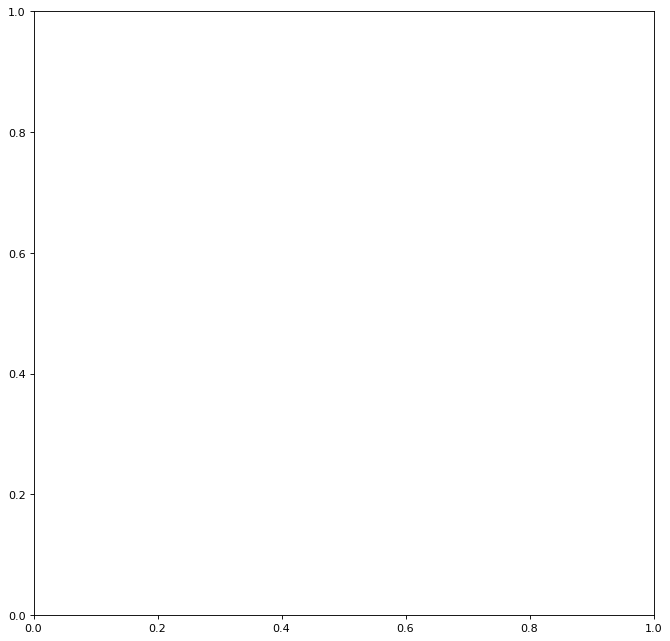

In [208]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10), dpi= 80, facecolor='w', edgecolor='k')
for key, peds in collision.items():
    (video, frame) = key
    scene_annotations_dataframe = scenes_annotations_dataframe[scenes_annotations_dataframe.video_name == video]
    
    video_num = video[-1]
    scene_name = video[:-2]
    
    path = '/home/q392358/Documents/FLORA/data/SDD/{}'.format(video)
    h_matrix = pd.read_csv(path + '/{}_homography.txt'.format(video), delim_whitespace=True, header=None).values
    
    filename = '/media/q392358/ba2b8f54-91f6-4e35-8323-e164edb98d11/stanford_campus_dataset/videos/{}/video{}/video.mov'.format(scene_name, video_num)
    vid = imageio.get_reader(filename,  'ffmpeg')      

    current_frame = scene_annotations_dataframe[scene_annotations_dataframe.frameID == frame]
    xy = np.transpose(np.stack([current_frame.x, current_frame.y]))
    pixels = get_pixels_from_world(xy, h_matrix)
    obstacles = get_pixels_from_world(occupancy_map, h_matrix)
    image = vid.get_data(int(frame))
    fig = pylab.figure(1)

    m, s = divmod(frame//frame_rate, 60)
    fig.suptitle('{} {}:{}'.format(video, m, s), fontsize=20)
    display.clear_output(wait=True)
    display.display(plt.gcf())
    ax.clear()
    ax.imshow(image)
    ax.scatter(pixels[:, 0], pixels[:, 1], color='blue')
    for couple in peds:
        pixs = get_pixels_from_world(np.vstack([get_position(current_frame, couple[0]), get_position(current_frame, couple[1])]), h_matrix)
        ax.scatter(pixs[:, 0], pixs[:, 1], color='red')
    ax.axis('off')

    time.sleep(0.1)
    
pylab.show()

## Visualize pedestrians close to obstacles

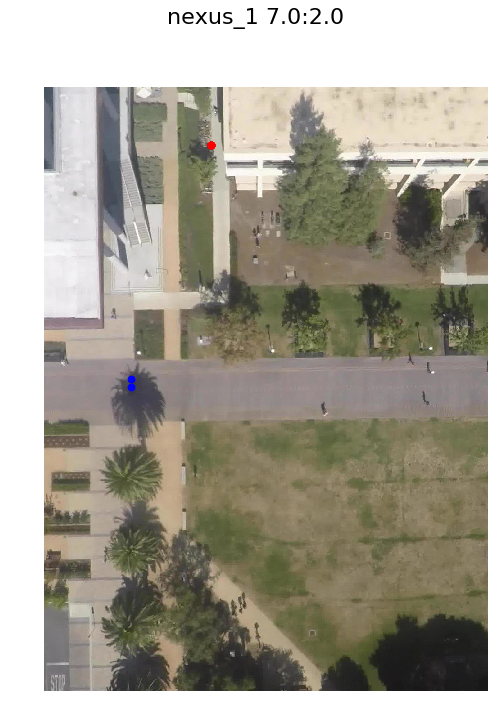

IndexError: Reached end of video

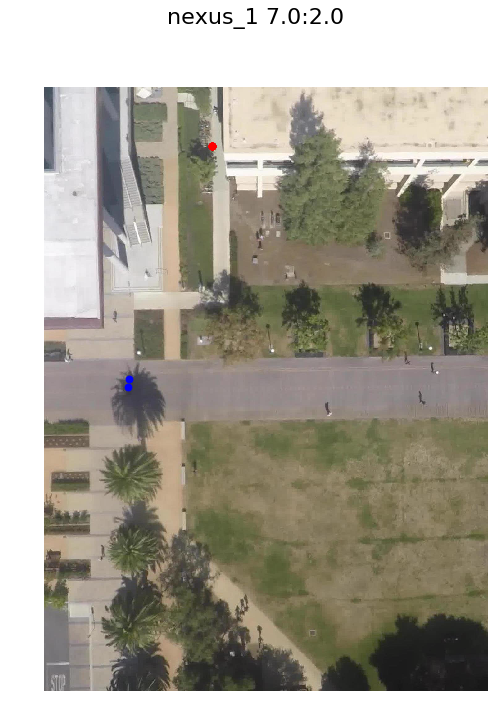

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10), dpi= 80, facecolor='w', edgecolor='k')
for key, peds in hits.items():
    (video, frame) = key
    scene_annotations_dataframe = scenes_annotations_dataframe[scenes_annotations_dataframe.video_name == video]
    frames = scene_annotations_dataframe.frameID.unique()
    video_num = video[-1]
    scene_name = video[:-2]
    
    path = '/home/q392358/Documents/FLORA/data/SDD/{}'.format(video)
    h_matrix = pd.read_csv(path + '/{}_homography.txt'.format(video), delim_whitespace=True, header=None).values
    occupancy_map = np.load(path + '/world_points.npy')
    
    filename = '/media/q392358/ba2b8f54-91f6-4e35-8323-e164edb98d11/stanford_campus_dataset/videos/{}/video{}/video.mov'.format(scene_name, video_num)
    vid = imageio.get_reader(filename,  'ffmpeg')
    #frame_rate = len(vid)/len(frames)        

    current_frame = scene_annotations_dataframe[scene_annotations_dataframe.frameID == frame]
    xy = np.transpose(np.stack([current_frame.x, current_frame.y]))
    pixels = get_pixels_from_world(xy, h_matrix)
    obstacles = get_pixels_from_world(occupancy_map, h_matrix)
    image = vid.get_data(int(frame))
    fig = pylab.figure(1)

    m, s = divmod(frame//frame_rate, 60)
    fig.suptitle('{} {}:{}'.format(video, m, s), fontsize=20)
    display.clear_output(wait=True)
    display.display(plt.gcf())
    ax.clear()
    ax.imshow(image)
    ax.scatter(pixels[:, 0], pixels[:, 1], color='blue')
    #ax.scatter(obstacles[:, 0], obstacles[:, 1], color='black', alpha=0.1, marker='s')

    pixs = get_pixels_from_world(peds, h_matrix)
    ax.scatter(pixs[:, 0], pixs[:, 1], color='red')
    ax.axis('off')

    time.sleep(0.1)
    
pylab.show()